# Metrics Evaluation Lab
##### Michael Carlson

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics
from numpy import log


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 
  
# metadata 
print(secondary_mushroom.metadata) 
  
# variable information 
print(secondary_mushroom.variables) 


{'uci_id': 848, 'name': 'Secondary Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv', 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 61068, 'num_features': 20, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2021, 'last_updated': 'Wed Apr 10 2024', 'dataset_doi': '10.24432/C5FP5Q', 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'], 'intro_paper': {'ID': 259, 'type': 'NATIVE', 'title': 'Mushroom data creation, curation, and simulation to support classification tasks', 'authors': 'Dennis Wagner, D. Heider, Georges Hattab', 'venue': 'Scientific Reports', 'year': 2021, 'journal': None, '

In [7]:
X.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


## Question:
Can we predict whether the Mushroom is poisonous based on cap features?

In [20]:
#drop unnecessary columns

# Ensure all columns have the same length and drop rows with NaN values
df = X[['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color']].dropna()
df = df.join(y.loc[df.index])
df.head()


,cap-diameter,cap-shape,cap-surface,cap-color,class
0,15.26,x,g,o,p
1,16.60,x,g,o,p
2,14.07,x,g,o,p
3,14.17,f,h,e,p
4,14.64,x,h,o,p


In [28]:
def clean_and_split(df, target, categories, test_size=0.4, val_size=0.5, random_state=1984):
    #numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    #scaler = preprocessing.MinMaxScaler()
    #df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    cat_cols = categories
    df[cat_cols] = df[cat_cols].astype('category')  
    df = pd.get_dummies(df, columns=cat_cols)
    
    # One-hot encode target
    df = pd.get_dummies(df, columns=[target], prefix=target)
    

    # Split data into train, test, and validation sets
    train, test = train_test_split(df, test_size=test_size, stratify=df[[f'{target}_e', f'{target}_p']], random_state=random_state)
    test, val = train_test_split(test, test_size=val_size, stratify=test[[f'{target}_e', f'{target}_p']], random_state=random_state)
    
    X1_train = train.drop([f'{target}_e', f'{target}_p'], axis=1)
    y1_train = train[[f'{target}_e', f'{target}_p']].idxmax(axis=1)
    
    X1_test = test.drop([f'{target}_e', f'{target}_p'], axis=1)
    y1_test = test[[f'{target}_e', f'{target}_p']].idxmax(axis=1)
    
    X1_val = val.drop([f'{target}_e', f'{target}_p'], axis=1)
    y1_val = val[[f'{target}_e', f'{target}_p']].idxmax(axis=1)
    
    return X1_train, y1_train, X1_test, y1_test, X1_val, y1_val

X1_train, y1_train, X1_test, y1_test, X1_val, y1_val = clean_and_split(df,'class', ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color'])

In [32]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X1_train, y1_train)


# Evaluate model
train_accuracy = neigh.score(X1_train, y1_train)
val_accuracy = neigh.score(X1_val, y1_val)
test_accuracy = neigh.score(X1_test, y1_test)


print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

y_test_pred = neigh.predict(X1_test)
y_test_prob = neigh.predict_proba(X1_test)


Training Accuracy: 0.9114274557137279
Validation Accuracy: 0.8335463258785942
Test Accuracy: 0.8298189563365282


In [34]:
y_val_pred = neigh.predict(X1_val)
results = pd.DataFrame({
    'Actual': y1_test.tolist(),
    'Predicted': y_test_pred.tolist(),
    'Probabilities': y_test_prob.tolist()
})

print(results.head())

    Actual Predicted Probabilities
0  class_e   class_e    [1.0, 0.0]
1  class_e   class_e    [1.0, 0.0]
2  class_p   class_p    [0.0, 1.0]
3  class_e   class_e    [1.0, 0.0]
4  class_e   class_p    [0.0, 1.0]


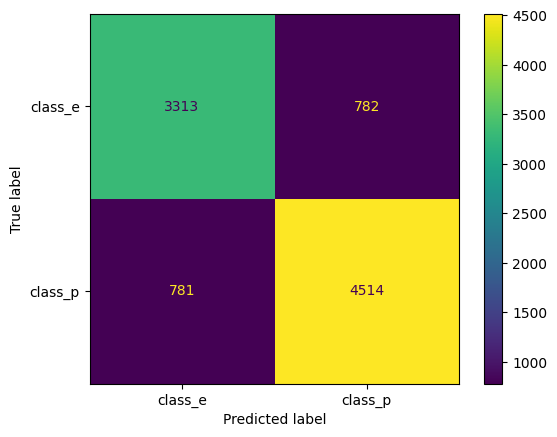

In [35]:
cm = confusion_matrix(y1_val, y_val_pred, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()
plt.show()

In [36]:
print(classification_report(y1_val, y_val_pred))

              precision    recall  f1-score   support

     class_e       0.81      0.81      0.81      4095
     class_p       0.85      0.85      0.85      5295

    accuracy                           0.83      9390
   macro avg       0.83      0.83      0.83      9390
weighted avg       0.83      0.83      0.83      9390



In [43]:
Accuracy = metrics.accuracy_score(y1_val, y_val_pred)
Precision = metrics.precision_score(y1_val, y_val_pred, average='weighted')
TruePositive = metrics.recall_score(y1_val, y_val_pred, average='weighted')
F1Score = metrics.f1_score(y1_val, y_val_pred, average='weighted')
CrossEntropy = log(1 - Accuracy) / log(Accuracy)
Roc = metrics.roc_auc_score(y1_val, y_test_prob[:, 1])
fp = cm[0][1]
tn = cm[1][0]
Fpr = fp/ (fp + tn)
print(f"False Positive Rate: {Fpr}")
print(f"Cross Entropy: {CrossEntropy}")
print(f"ROC AUC: {Roc}")
print(f"Accuracy: {Accuracy}")
print(f"Precision: {Precision}")
print(f"True Positive Rate: {TruePositive}")
print(f"F1 Score: {F1Score}")


False Positive Rate: 0.5003198976327575
Cross Entropy: 9.84828720114136
ROC AUC: 0.49350376619498426
Accuracy: 0.8335463258785942
Precision: 0.8335417349983183
True Positive Rate: 0.8335463258785942
F1 Score: 0.8335440208912033


These metrics tell me that the model is good at predicting Poisonous mushrooms, but not as good at predicting edible mushrooms.

#### Q3. In consideration of all the metrics you just used are there a few that seem more important given the question you are asking? Why?
> The most important is True positive and false negative since we want to be sure that we are not misclassifying poisonous mushrooms as edible. 

#### Q4. Consider where classification errors are occurring, is there a pattern? If so discuss this pattern and why you think this is the case.
> 